In [53]:
import ipywidgets as widgets
import openvino as ov
import cv2
import numpy as np
import time
from PIL import Image
import warnings
import tensorflow as tf
import matplotlib.pyplot as plt

In [257]:
padding_modulo = 64
def pad_image(image):
    h, w, c = image.shape
    # Add pad value to make sure the size of image is the same as size of input
    # This
    pad_h = int(np.ceil(h/padding_modulo)*padding_modulo-h)
    pad_w = int(np.ceil(w/padding_modulo)*padding_modulo-w)    
    padded_image = np.pad(image, ((0, pad_h), (0, pad_w), (0, 0)), 
                          mode='constant', 
                          constant_values=0)

def unpad_image(image, pad_h, pad_w):
    return image[:-pad_h, :-pad_w, :] if pad_h > 0 and pad_w > 0 else image
    
def normalize(image: np.ndarray) -> np.ndarray:
    """
    Normalize the image to the given mean and standard deviation
    for CityScapes models.
    """
    image = image.astype(np.float32)
    mean = (0.485, 0.456, 0.406)
    std = (0.229, 0.224, 0.225)
    image /= 255.0
    image -= mean
    image /= std
    return image

def postprocess_image(output_array):
    output_array = np.clip(output_array, 0, 1)  # Ensure the values are within [0, 1]
    output_array = (output_array * 255).astype(np.uint8)  # Denormalize the image    
    # output_array = cv2.cvtColor(output_array, cv2.COLOR_RGB2BGR)
    print(output_array.shape)
    output_image = Image.fromarray(output_array)
    return output_image

def show_image(img_path, cmap=None):
    '''Show image '''
    # plt.close('all')
    data = cv2.imread(img_path)
    data = cv2.cvtColor(data, cv2.COLOR_BGR2RGB)
    plt.imshow(data, cmap=cmap)
    plt.show()
    return np.asarray(data)
    
def digest_input(img_path):
    '''
    # input digestion
    Ex: 
    img_path = 'input.jpg'
    normalized_input_image = digest_input(img_path)
    '''    
    image = cv2.imread(img_path)    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # (880, 480, 3) # (w,h,c)     
    height, width, channels = image.shape    
    new_size = (50 , 50)  # Width, Height   
    # new_size = (480 , 270)  # Width, Height
    image = cv2.resize(image, new_size, interpolation=cv2.INTER_LINEAR) # (50, 50, 3)
    cv2.imwrite('resized_image.jpg', image)
    ## Preprocess 
    # Normalize in range (0;1)
    image = np.array(image).astype(np.float32) / 255.0  # Normalize the image      
    # Expand dimensions for the network
    normalized_input_image = np.expand_dims(image, 0)# (1,50, 50, 3)
    return normalized_input_image

def restructure_image(predicted_tensor):
    '''
    output_image = restructure_image()
    (1, 1080, 1920, 3)
    '''
    # Remove batch dimension 
    # (1, 1080, 1920, 3)-> (1080, 1920, 3)
    output_image = np.squeeze(predicted_tensor, axis=0)  
    # Post process
    output_image = postprocess_image(output_image)
    return output_image

# Get model details
def print_model_details(interpreter):
    #print_model_details(interpreter)
    # Get tensor details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    print("Input Details:")
    for detail in input_details:
        print(f"Name: {detail['name']}, Shape: {detail['shape']}, dtype: {detail['dtype']}")
    
    print("\nOutput Details:")
    for detail in output_details:
        print(f"Name: {detail['name']}, Shape: {detail['shape']}, dtype: {detail['dtype']}")

In [260]:
img_path = 'lr-1.jpg'
normalized_input_image = digest_input(img_path)
normalized_input_image.shape

(1, 50, 50, 3)

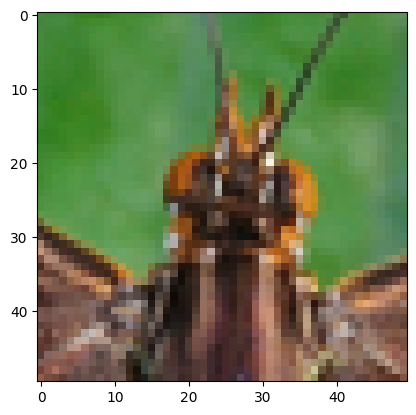

In [261]:
_ = show_image(img_path)

In [262]:
model_path = 'models/ESRGAN.tflite'
interpreter = tf.lite.Interpreter(model_path=model_path)
interpreter.allocate_tensors()

In [263]:
print_model_details(interpreter)

Input Details:
Name: input_0, Shape: [ 1 50 50  3], dtype: <class 'numpy.float32'>

Output Details:
Name: Identity, Shape: [  1 200 200   3], dtype: <class 'numpy.float32'>


In [264]:
# Set the input tensor
input_details = interpreter.get_input_details()
input_index = input_details[0]['index']
interpreter.set_tensor(input_index, normalized_input_image)

# Run inference
start = time.time()
interpreter.invoke()
end = time.time()
print(f"inf time {end-start}")

output_details = interpreter.get_output_details()
output_index = output_details[0]['index']
output_data = interpreter.get_tensor(output_index)

inf time 0.11168551445007324


In [265]:
output_image = restructure_image(output_data)
output_path = 'output_Python.jpg'
output_image.save(output_path)

(200, 200, 3)


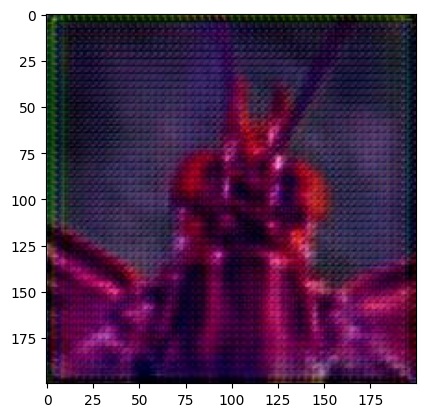

In [266]:
a = show_image(output_path)